<a href="https://colab.research.google.com/github/ishankarve/Linear-Regression/blob/main/Multiple%20Linear%20Regression%20in%20Python/Assignment/Bike%20Sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Objective**
Build a multiple linear regression model for the prediction of demand for shared bikes. 

### **Problem Statement**

A US bike-sharing provider **BoomBikes** has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. 


### **Business Goal**

Find variables are significant in predicting the demand for shared bikes and how well those variables describe the bike demands
Based on various **meteorological surveys** and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

Based on the goal mentioned above, model the demand for shared bikes with the available independent variables.

### **Data Caveats**

1.   In the dataset that some of the variables like 'weathersit' and 'season' have values as 1, 2, 3, 4 which have specific labels associated with them (as described in the data dictionary). These numeric values associated with the labels may indicate that there is some order to them - which is actually not the case. So, it is advisable to convert such feature values into categorical string values before proceeding with model building.

2.  The column 'yr' has two values 0 and 1 indicating the years 2018 and 2019 respectively. Since these bike-sharing systems are slowly gaining popularity, the demand for these bikes is increasing every year proving that the column 'yr' might be a good variable for prediction. So think twice before dropping it. 


### **Model Building**

In the dataset provided,there are three columns named 'casual', 'registered', and 'cnt'. The variable 'casual' indicates the number casual users who have made a rental. The variable 'registered' on the other hand shows the total number of registered users who have made a booking on a given day. Finally, the 'cnt' variable indicates the total number of bike rentals, including both casual and registered. ***The model should be built taking this 'cnt' as the target variable.***

### **Step 1: Import Libraries**


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### **Step 2: Import Data**

In [3]:
#import data from gihub link
df_bikeshare=pd.read_csv("https://raw.githubusercontent.com/ishankarve/Linear-Regression/main/Multiple%20Linear%20Regression%20in%20Python/Assignment/day.csv")

In [4]:
df_bikeshare.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### **Data Dictionary**
- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

### **Step 3: Undertake sanity checks on data**

In [5]:
#get shape of the dataframe
df_bikeshare.shape

(730, 16)

In [6]:
#check column dtypes
df_bikeshare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [7]:
#get list of unique variables per column
print(df_bikeshare.nunique())

instant       730
dteday        730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
casual        605
registered    678
cnt           695
dtype: int64


In [8]:
# get count of non-na values across all columns
df_bikeshare.apply(lambda x: x.count(), axis=0)

instant       730
dteday        730
season        730
yr            730
mnth          730
holiday       730
weekday       730
workingday    730
weathersit    730
temp          730
atemp         730
hum           730
windspeed     730
casual        730
registered    730
cnt           730
dtype: int64

In [9]:
# convert 'dteday' from 'object' to 'datetime'
df_bikeshare['dteday'] = pd.to_datetime(df_bikeshare['dteday'], format='%d-%m-%Y') #date is in 01-01-2018 format

In [10]:
#describe dataframe
df_bikeshare.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### **Step 4: Cleaning & Binning Categorical Data**

In [32]:
# binning windspeed data as per Beaufort Scale (https://www.rmets.org/metmatters/beaufort-scale)
# Note: Since temperature is in metric units (deg Celsius), it is assumed that windspeed is in Km/Hr

bin_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
bins = [0, 1, 5, 11, 19, 28, 38, 49, 61, 74, 88, 102, 117,300]
df_bikeshare['windspeed_binned'] = pd.cut(df_bikeshare['windspeed'], bins=bins, labels=bin_labels)

,windspeed,windspeed_binned
0,10.749882,2
1,16.652113,3
2,16.636703,3
3,10.739832,2
4,12.522300,3
...,...,...
725,23.458911,4
726,10.416557,2
727,8.333661,2
728,23.500518,4


In [38]:
# binning temperature data as per comfort Scale (http://www.city-data.com/forum/weather/1620160-your-personal-temperature-colors-descriptors.html)
# data is binned as follows
# data is binned on a scale of 1 to 12
# 12- 45C & up: extremely hot 
# 11- 40 to 45C: very hot 
# 10- 35 to 40C: hot 
# 09- 30 to 35C: quite warm 
# 08 -20 to 30C: ideal 
# 07- 15 to 20C: lower than ideal 
# 06- 10 to 15C: cool 
# 05- 5 to 10C: quite cool 
# 04- 0 to 5C: cold 
# 03 -5 to 0C: very cold 
# 02- -10 to -5C: freezing 
# 01- -15 to -10C: frigid

bin_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
bins = [-15,-10,-5,0,5,10,15,20,30,35,40,45,60]
df_bikeshare['temp_binned'] = pd.cut(df_bikeshare['temp'], bins=bins, labels=bin_labels)
df_bikeshare[['temp','temp_binned']]

,temp,temp_binned
0,14.110847,6
1,14.902598,6
2,8.050924,5
3,8.200000,5
4,9.305237,5
...,...,...
725,10.420847,6
726,10.386653,6
727,10.386653,6
728,10.489153,6


### **Step 5: Prelimnary Visualisation**
Since all data is numeric, we can use plots to visualise data 

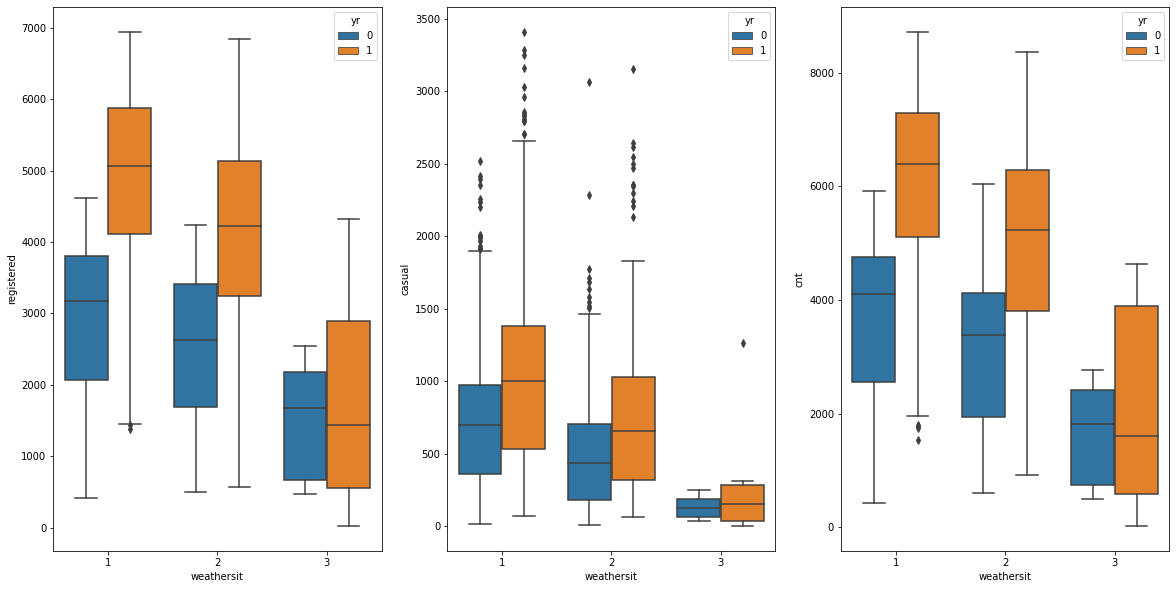

In [51]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'weathersit', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'weathersit', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'weathersit', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.show()

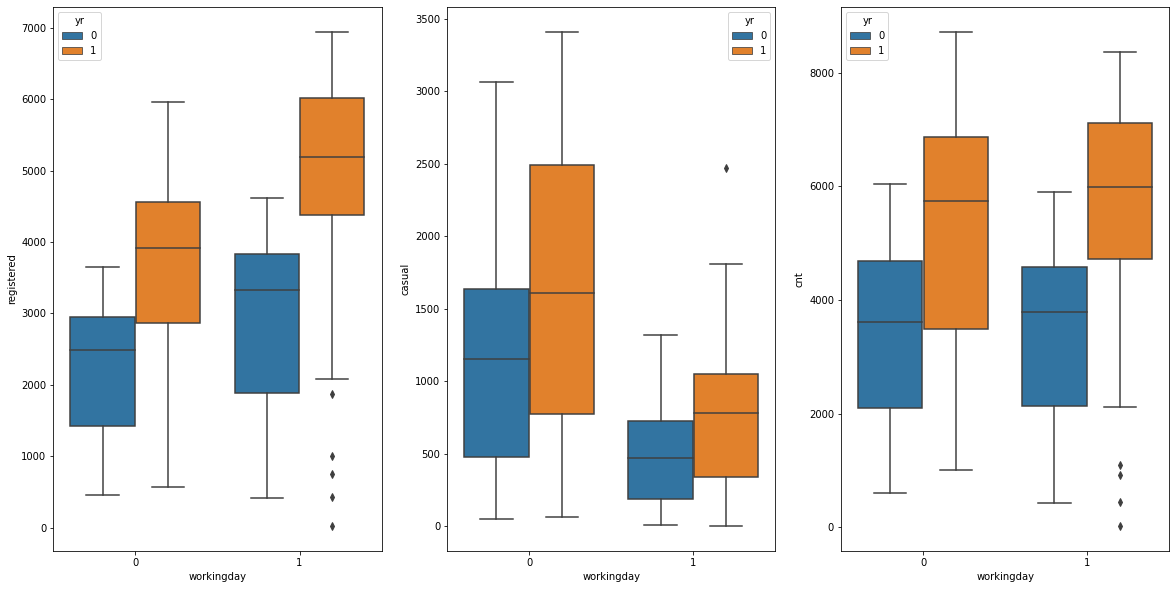

In [52]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'workingday', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'workingday', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'workingday', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.show()

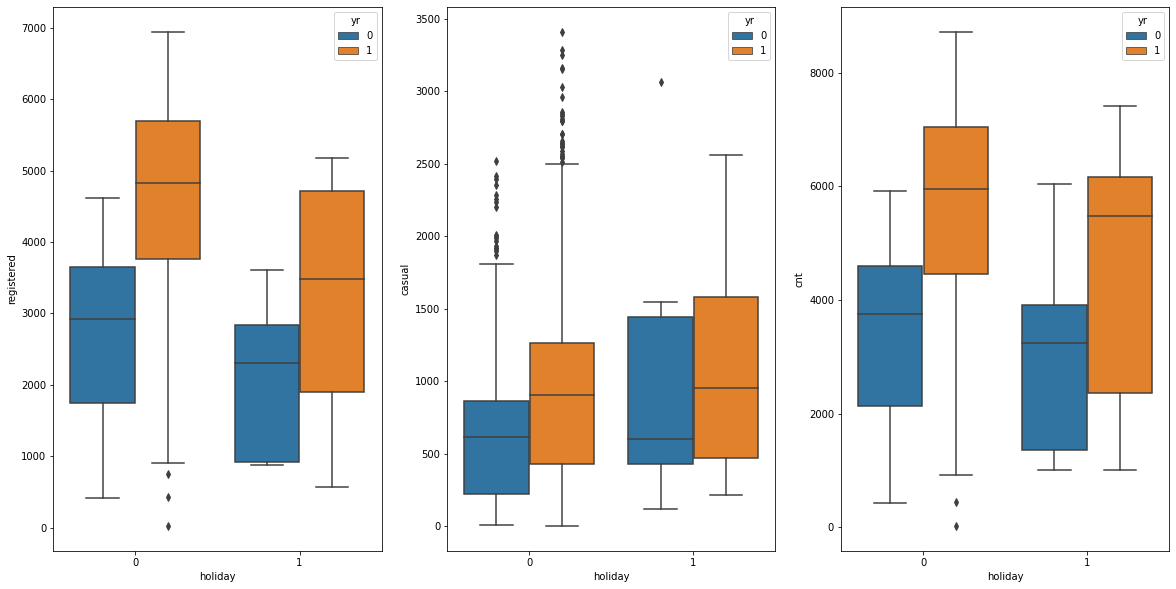

In [53]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'holiday', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'holiday', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'holiday', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.show()

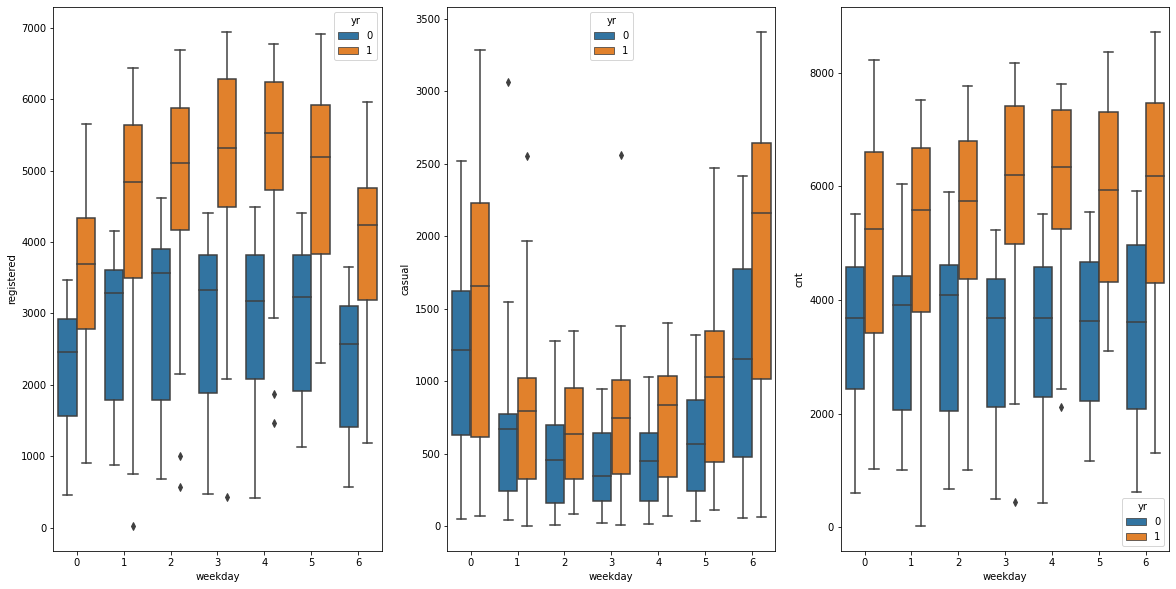

In [54]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'weekday', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'weekday', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'weekday', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.show()

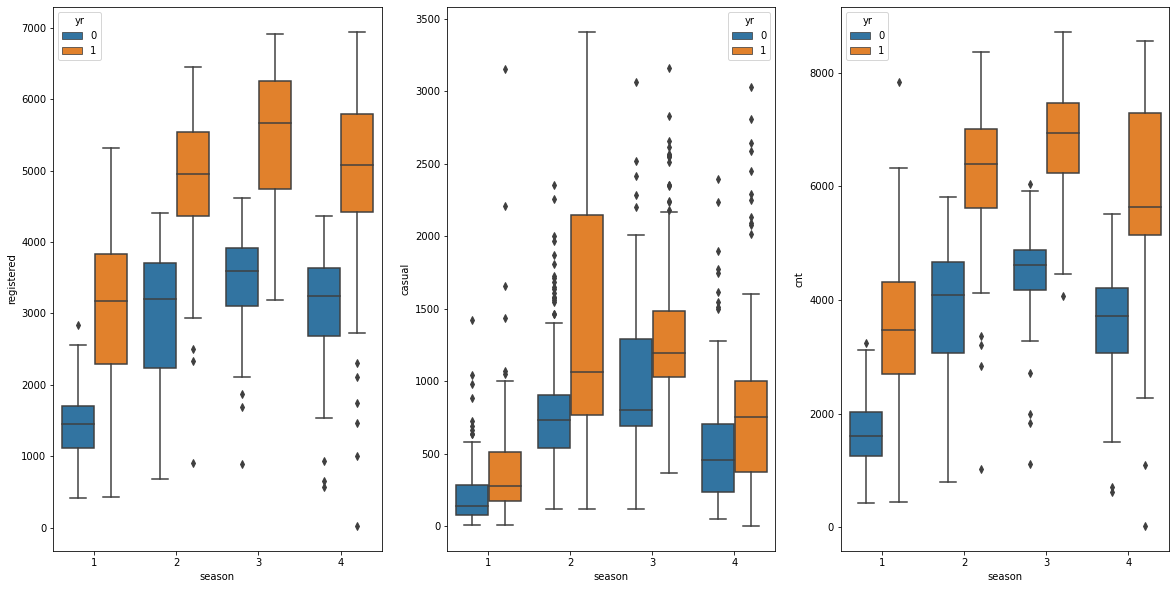

In [55]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'season', y = 'registered', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'season', y = 'casual', hue = 'yr', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'season', y = 'cnt', hue = 'yr', data = df_bikeshare)
plt.show()

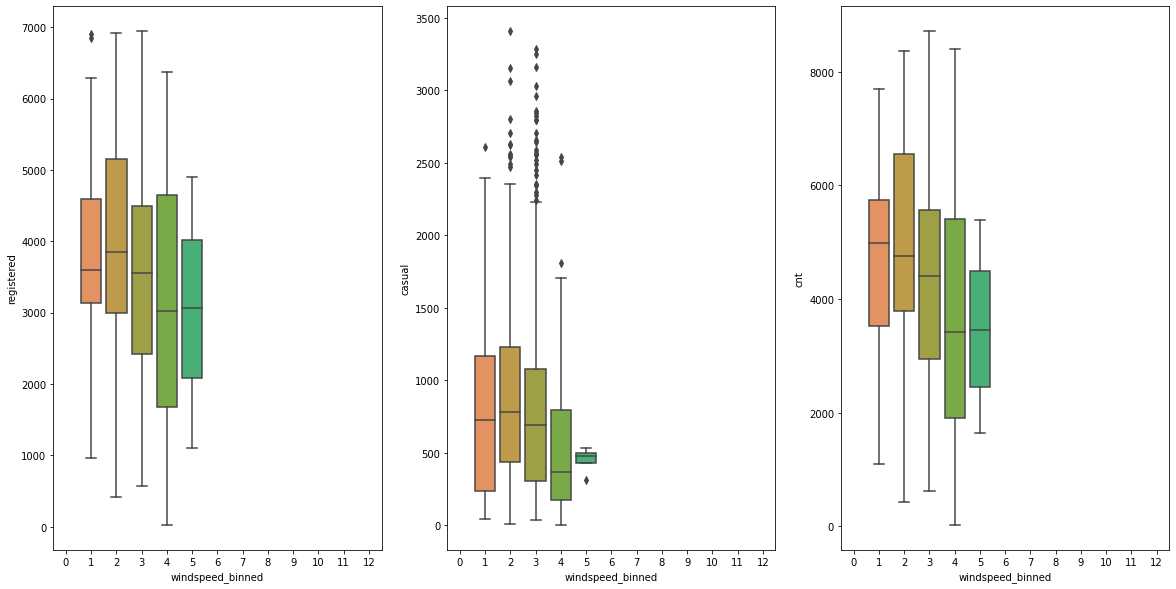

In [56]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'windspeed_binned', y = 'registered', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'windspeed_binned', y = 'casual', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'windspeed_binned', y = 'cnt', data = df_bikeshare)
plt.show()

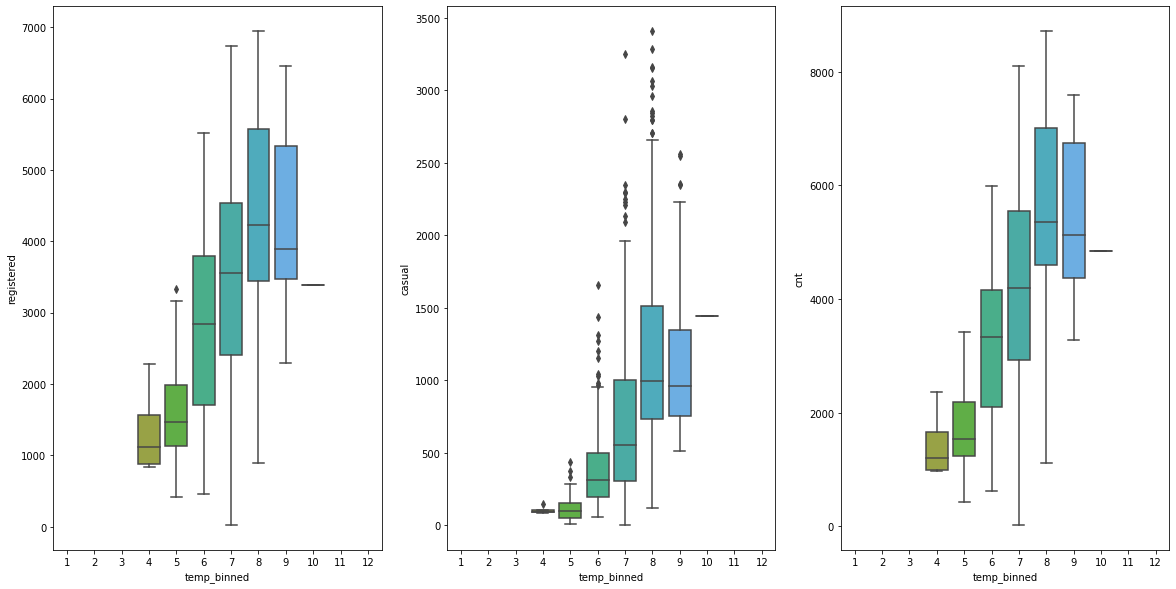

In [57]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'temp_binned', y = 'registered', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'temp_binned', y = 'casual', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'temp_binned', y = 'cnt', data = df_bikeshare)
plt.show()

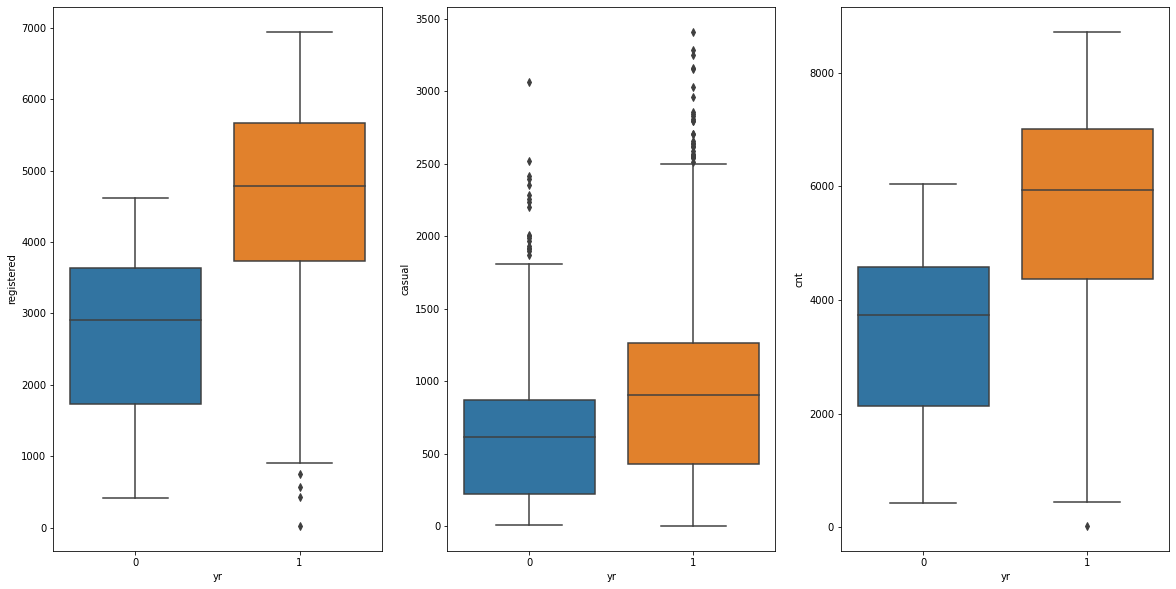

In [58]:
#plotting data for comparative analysis
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.boxplot(x = 'yr', y = 'registered', data = df_bikeshare)
plt.subplot(1,3,2)
sns.boxplot(x = 'yr', y = 'casual', data = df_bikeshare)
plt.subplot(1,3,3)
sns.boxplot(x = 'yr', y = 'cnt', data = df_bikeshare)
plt.show()